#Predict Melbourne House Pricing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
tqdm.pandas()
%matplotlib inline
warnings.filterwarnings("ignore")

/home/dickyalsyah/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Load Dataset

In [2]:
house = pd.read_csv('melb_data.csv')

In [3]:
house.dropna(axis = 0, inplace = True)

In [4]:
house = house.iloc[0:5000]

In [5]:
house.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0.0,245.0,210.0,1910.0,Yarra,-37.8024,144.9993,Northern Metropolitan,4019.0
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2.0,256.0,107.0,1890.0,Yarra,-37.8060,144.9954,Northern Metropolitan,4019.0


Finding the insight on the next big trend to become a real estate mogul.

Notes on Specific Variables:

* Rooms: Number of rooms
* Price: Price in dollars
* Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.
* Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.
* SellerG: Real Estate Agent
* Date: Date sold
* Distance: Distance from CBD
* Regionname: General Region (West, North West, North, North east …etc)
* Propertycount: Number of properties that exist in the suburb.
* Bedroom2 : Scraped # of Bedrooms (from different source)
* Bathroom: Number of Bathrooms
* Car: Number of carspots
* Landsize: Land Size
* BuildingArea: Building Size
* CouncilArea: Governing council for the area

In [6]:
house.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2.901400,1.099285e+06,8.876280,3096.330600,2.86500,1.565400,1.542200,451.410800,140.870004,1961.929000,-37.808262,144.987092,7408.962400
std,0.971734,6.916444e+05,4.368428,67.889957,0.96962,0.715979,0.929081,886.684955,93.432237,37.634474,0.065853,0.082587,4321.588198
min,1.000000,1.310000e+05,0.000000,3000.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1830.000000,-38.164920,144.558330,389.000000
25%,2.000000,6.350000e+05,5.900000,3042.000000,2.00000,1.000000,1.000000,138.000000,89.000000,1930.000000,-37.852600,144.929075,4442.000000
50%,3.000000,9.030000e+05,8.500000,3079.000000,3.00000,1.000000,1.000000,338.000000,122.000000,1965.000000,-37.802600,144.993300,6567.000000
75%,3.000000,1.370000e+06,11.400000,3146.000000,3.00000,2.000000,2.000000,614.000000,169.000000,1999.000000,-37.761200,145.047325,9264.000000
max,8.000000,8.000000e+06,45.900000,3806.000000,9.00000,8.000000,10.000000,37000.000000,3112.000000,2018.000000,-37.487010,145.526350,21650.000000


## A. Data Cleaning & Preprocessing

In [7]:
# Check Missing Value on the Data
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 9670
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         5000 non-null   object 
 1   Address        5000 non-null   object 
 2   Rooms          5000 non-null   int64  
 3   Type           5000 non-null   object 
 4   Price          5000 non-null   float64
 5   Method         5000 non-null   object 
 6   SellerG        5000 non-null   object 
 7   Date           5000 non-null   object 
 8   Distance       5000 non-null   float64
 9   Postcode       5000 non-null   float64
 10  Bedroom2       5000 non-null   float64
 11  Bathroom       5000 non-null   float64
 12  Car            5000 non-null   float64
 13  Landsize       5000 non-null   float64
 14  BuildingArea   5000 non-null   float64
 15  YearBuilt      5000 non-null   float64
 16  CouncilArea    5000 non-null   object 
 17  Lattitude      5000 non-null   float64
 18  Longtitu

In [8]:
house.isna().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

In [9]:
house.BuildingArea.describe()

count    5000.000000
mean      140.870004
std        93.432237
min         0.000000
25%        89.000000
50%       122.000000
75%       169.000000
max      3112.000000
Name: BuildingArea, dtype: float64

In [10]:
# Handling 0 Value in Building Area
house[house['BuildingArea'] == 0]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
4344,North Melbourne,19 Shands La,2,t,841000.0,S,Jellis,4/03/2017,2.3,3051.0,...,1.0,1.0,215.0,0.0,2000.0,Melbourne,-37.7953,144.9437,Northern Metropolitan,6821.0


In [11]:
# Fill 0 with landsize in the same index
house['BuildingArea'].replace(0, 215.0, inplace=True)

In [12]:
house['Suburb'].nunique()

230

In [13]:
house['Type'].unique()

array(['h', 'u', 't'], dtype=object)

In [14]:
house['Method'].unique()

array(['S', 'SP', 'VB', 'PI', 'SA'], dtype=object)

In [15]:
house['CouncilArea'].unique()

array(['Yarra', 'Moonee Valley', 'Port Phillip', 'Darebin', 'Hobsons Bay',
       'Stonnington', 'Boroondara', 'Monash', 'Glen Eira', 'Whitehorse',
       'Maribyrnong', 'Bayside', 'Moreland', 'Manningham', 'Banyule',
       'Kingston', 'Brimbank', 'Melbourne', 'Hume', 'Knox', 'Melton',
       'Maroondah', 'Greater Dandenong', 'Nillumbik', 'Whittlesea',
       'Frankston', 'Macedon Ranges', 'Yarra Ranges', 'Wyndham', 'Casey'],
      dtype=object)

In [16]:
house['Regionname'].unique()

array(['Northern Metropolitan', 'Western Metropolitan',
       'Southern Metropolitan', 'Eastern Metropolitan',
       'South-Eastern Metropolitan', 'Northern Victoria',
       'Eastern Victoria', 'Western Victoria'], dtype=object)

**Encode the Categorical Features**

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
house['Type_E'] = encoder.fit_transform(house['Type'])
house['Method_E'] = encoder.fit_transform(house['Method'])
house['Regionname_E'] = encoder.fit_transform(house['Regionname'])
house['CouncilArea_E'] = encoder.fit_transform(house['CouncilArea'])

house.head()


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Type_E,Method_E,Regionname_E,CouncilArea_E
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0,0,1,2,28
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0,0,3,2,28
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0,0,4,2,28
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,1910.0,Yarra,-37.8024,144.9993,Northern Metropolitan,4019.0,0,1,2,28
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1890.0,Yarra,-37.8060,144.9954,Northern Metropolitan,4019.0,0,1,2,28


## B. Exploratory Data Analysis

First, separating features based on their data types for further analysis

In [17]:
numerical_feature=[feature for feature in house.columns if house[feature].dtype !='object']
print('There are {} numerical features.'.format(len(numerical_feature)))

year=[feature for feature in numerical_feature if "Yr" in feature or "Year" in feature]

discrete_feature=[feature for feature in numerical_feature if (house[feature].nunique())<25 and feature not in year+['Id']]
print('There are {} are discrete features'.format(len(discrete_feature)) )

continuous_feature=[feature for feature in numerical_feature if feature not in discrete_feature and feature not in year+['Id']]
print('There are {} are continuous features'.format(len(continuous_feature)) )

cat_feature=[feature for feature in house.columns if house[feature].dtypes=='object']
print('There are {} categorical features.'.format(len(cat_feature)))

There are 13 numerical features.
There are 4 are discrete features
There are 8 are continuous features
There are 8 categorical features.


**Numerical Feature**

Outliers in continuous numeric features:

In [18]:
def outlier_function(df, col_name):
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

for feature in continuous_feature:
    if outlier_function(house,feature)[2] > 1:
        print('{}: {} outliers'.format(feature,outlier_function(house,feature)[2]))

Price: 47 outliers
Distance: 23 outliers
Postcode: 9 outliers
Landsize: 74 outliers
BuildingArea: 57 outliers
Lattitude: 2 outliers
Longtitude: 3 outliers


Let us now take a look at correlations within continuous features with the help of a heatmap. Later we shall see each of the feature in detail.

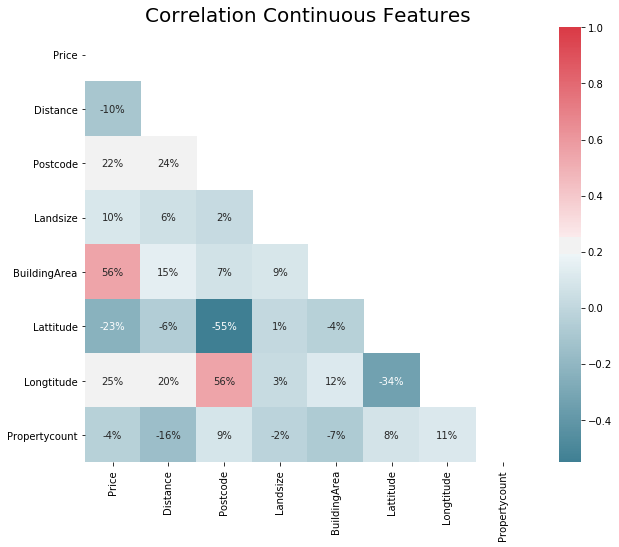

In [19]:
plt.figure(figsize=(10,8))
plt.title('Correlation Continuous Features', fontsize=20)
colormap = sns.diverging_palette(220, 10, as_cmap = True)
corr_matrix = house[continuous_feature].corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, annot=True, fmt = ".0%", cbar = True, cmap=colormap, mask=mask);

The above heatmap shows correlation between the above factors .

There is a negative correlation between price and distance from Central Business, it means that as people move farther away from central business district the house prices decrease. And the influential value lies in the Building Area, which is clear that this is very influential on house prices.

**Distribution of observations**

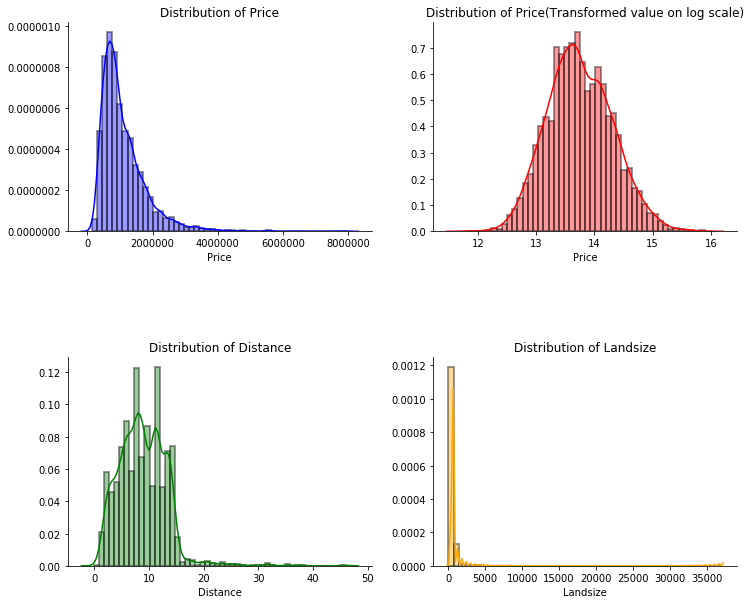

In [20]:
fig, axarr = plt.subplots(2, 2, figsize = (12, 10))

sns.distplot(house['Price'],ax = axarr[0][0],color = 'blue',hist_kws = dict(edgecolor="k", linewidth=2)).set_title('Distribution of Price')
sns.distplot(house['Distance'],ax = axarr[1][0],color = 'green',hist_kws = dict(edgecolor="k", linewidth=2)).set_title('Distribution of Distance')
sns.distplot(np.log(house['Price']),ax = axarr[0][1],color = 'red',hist_kws = dict(edgecolor="k", linewidth=2)).set_title('Distribution of Price(Transformed value on log scale)')
sns.distplot(house['Landsize'],ax = axarr[1][1],color = 'orange',hist_kws = dict(edgecolor="k", linewidth=2)).set_title('Distribution of Landsize')
plt.subplots_adjust(hspace=.6)
sns.set_style('darkgrid')
sns.despine()

In [21]:
#skewness and kurtosis
print("Skewness: %f" % house['Price'].skew())
print("Kurtosis: %f" % house['Price'].kurt())

Skewness: 2.258561
Kurtosis: 9.506135


We can see that log tranformed values of price has considerably reduced skew. thus for few plots we shall make use of log transformed values of price.

In [22]:
house['price_per_unit_area']=house['Price']/house['Landsize']

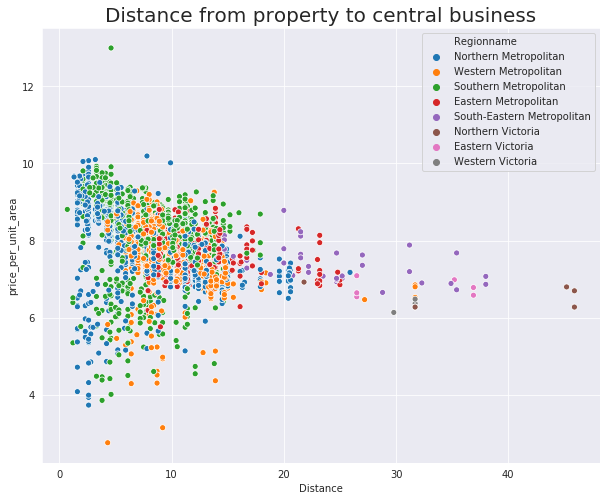

In [23]:
plt.figure(figsize=(10,8))
sns.scatterplot(y=np.log(house['price_per_unit_area']),x = house['Distance'],data=house,hue='Regionname').set_title("Distance from property to central business",fontsize=20);

Price of the houses on an average are same at distance farther away from central business. But the number of houses sold are less as we move away from central business. Also Northern Metropolitan, Southern Metropolitan and Western Metropolitan regions are nearer to central business

**Discrete features**

In [24]:
house[discrete_feature].head(3)

,Rooms,Bedroom2,Bathroom,Car
1,2,2.0,1.0,0.0
2,3,3.0,2.0,0.0
4,4,3.0,1.0,2.0


In [25]:
house['Bedroom2']=house['Bedroom2'].astype('int')
house['Bathroom']=house['Bathroom'].astype('int')
house['Car']=house['Car'].astype('int',errors='ignore')
house['Car']=house['Car'].astype('int',errors='ignore')

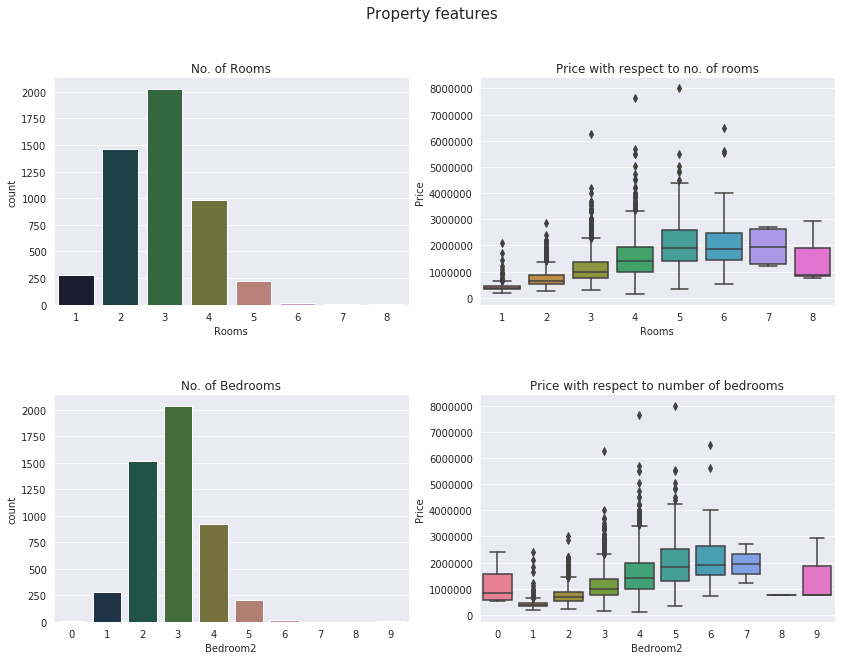

In [27]:
fig, axarr = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle('Property features',fontsize=15)

sns.countplot(house['Rooms'],ax=axarr[0][0],palette='cubehelix').set_title('No. of Rooms')
sns.countplot(house['Bedroom2'],ax=axarr[1][0],palette='cubehelix').set_title('No. of Bedrooms')
sns.boxplot(x=house['Bedroom2'],y=house['Price'],ax=axarr[1][1],palette='husl').set_title('Price with respect to number of bedrooms')
sns.boxplot(x=house['Rooms'],y=house['Price'],ax=axarr[0][1],palette='husl').set_title('Price with respect to no. of rooms')

plt.subplots_adjust(hspace=.4)
sns.set_style('darkgrid')
sns.despine()

There is no much variation in context of rooms and bedrooms. Houses that are most preffered have 2-3 rooms. Pricier houses have room count of 5.

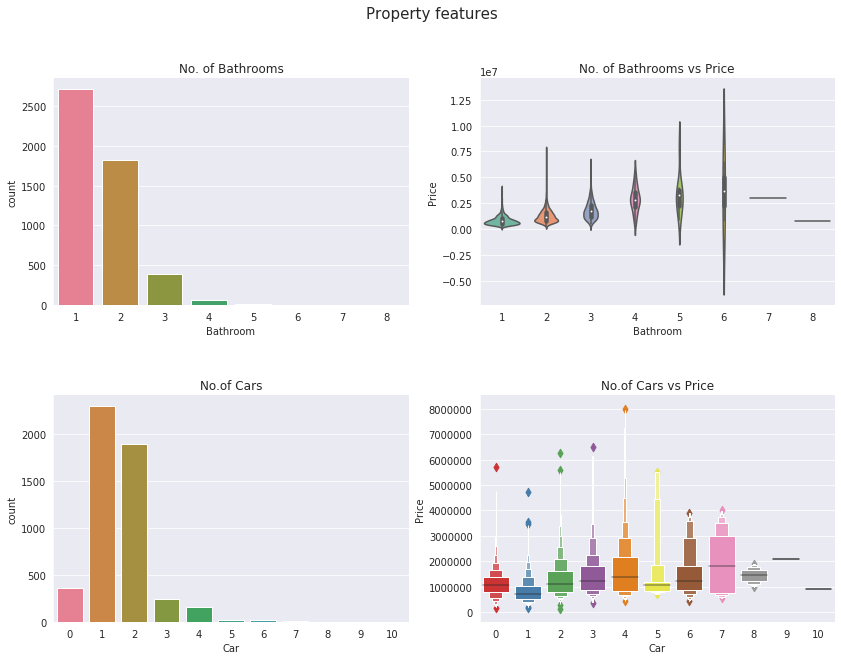

In [28]:
fig, axarr = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Property features',fontsize=15)

sns.countplot(house['Bathroom'],ax=axarr[0][0],palette='husl').set_title('No. of Bathrooms')
sns.violinplot(x= "Bathroom",y="Price",data=house,palette="Set2",ax=axarr[0][1]).set_title('No. of Bathrooms vs Price')
sns.countplot(house['Car'],ax=axarr[1][0],palette='husl').set_title('No.of Cars')
sns.boxenplot(x="Car",y="Price",data=house,palette="Set1",ax=axarr[1][1]).set_title('No.of Cars vs Price');


plt.subplots_adjust(hspace=.4)
sns.set_style('darkgrid')
sns.despine()

Properties, most commonly have either 1 or 2 bathrooms. Houses with more than 4 bathrooms tend to be expensive.Same trend goes iwth the number of cars.

**Categorical features**


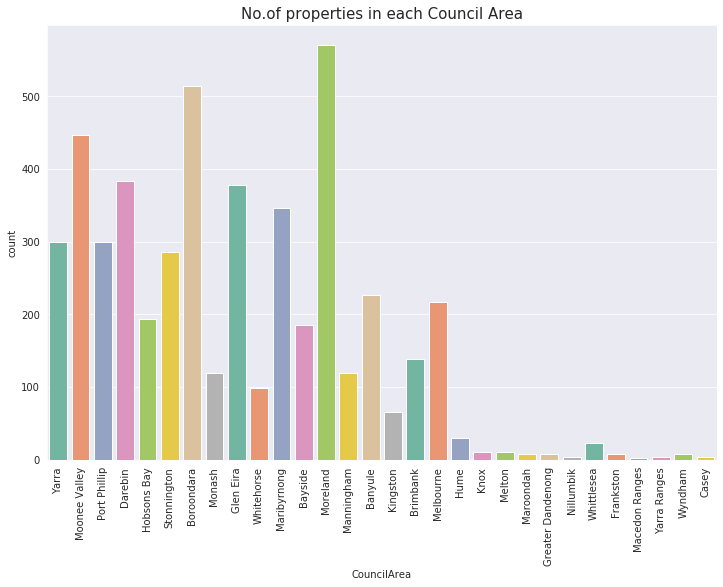

In [29]:
plt.figure(figsize=(12,8))
g=sns.countplot(house['CouncilArea'],data=house,palette='Set2')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('No.of properties in each Council Area',fontsize=15);

Council Area with most properties sold was Moreland and Boroondara , while council Moorabool saw the least sales.

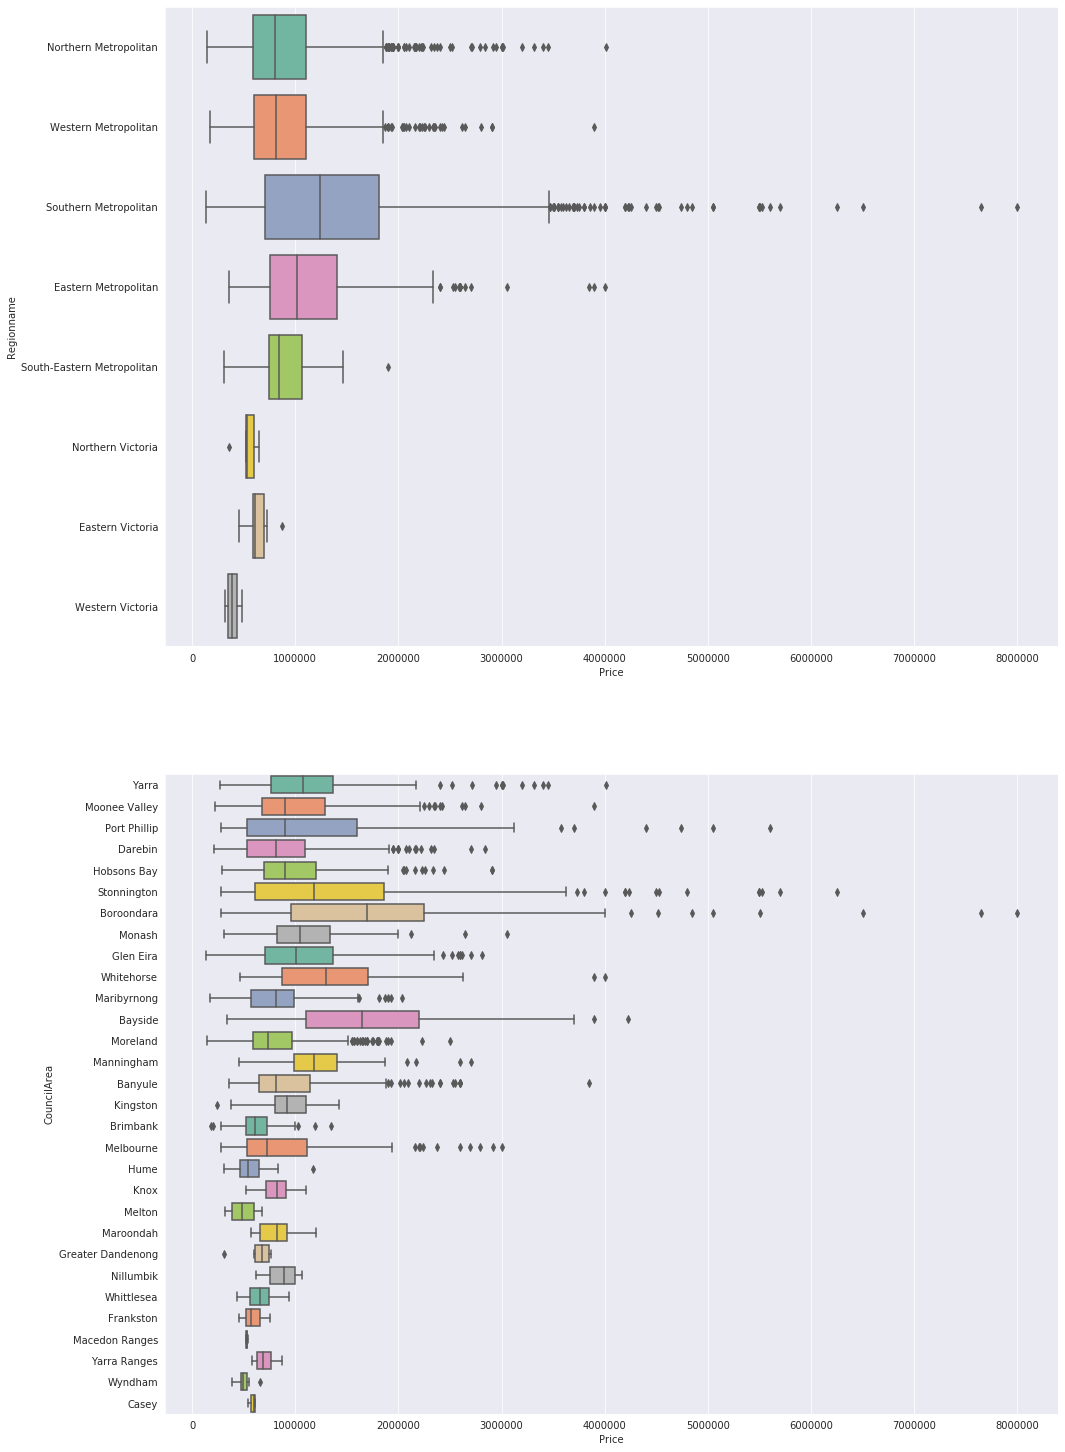

In [34]:
#analysis by Regional features
region_feature=['Regionname','CouncilArea']
plt.figure(figsize=(16,40))
i=1
for feature in region_feature:
    plt.subplot(3,1,i)
    sns.boxplot(y=house[feature],x=house['Price'],palette="Set2")
    plt.ylabel(feature)
    i+=1

* Buyers are willing to pay a higher price for houses in council area Boroondara and Stonnington. While lowest in Moorabool.
* Apart from houses being the most sold property,Unit type of property is also being sold in most of the concil areas

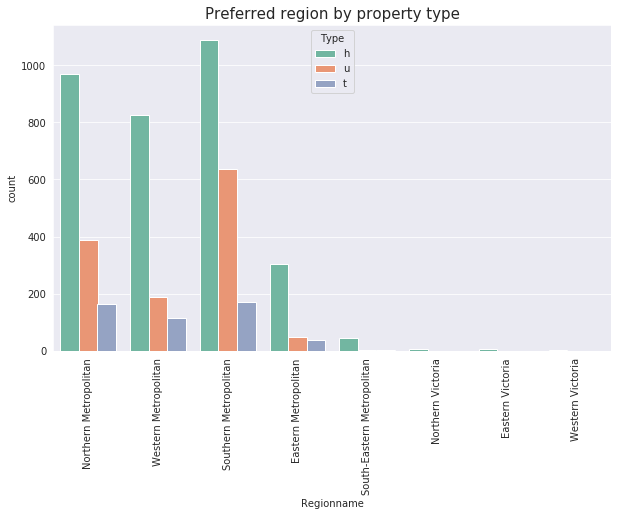

In [35]:
plt.figure(figsize=(10,6))
g=sns.countplot(house['Regionname'],hue='Type',data=house,palette='Set2')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Preferred region by property type',fontsize=15);

From the graph, we can see that from region wise graph Southern Metropolitan has the highest price and even the median is also high, and when we look on the counsil area graph Boroondra has the highest median and price which belongs to the southern metropolitan and the lowest is moorabool and melton from the Western Victoria region

Let us now see the trend in pricing with respect to the year in which these properties were built.

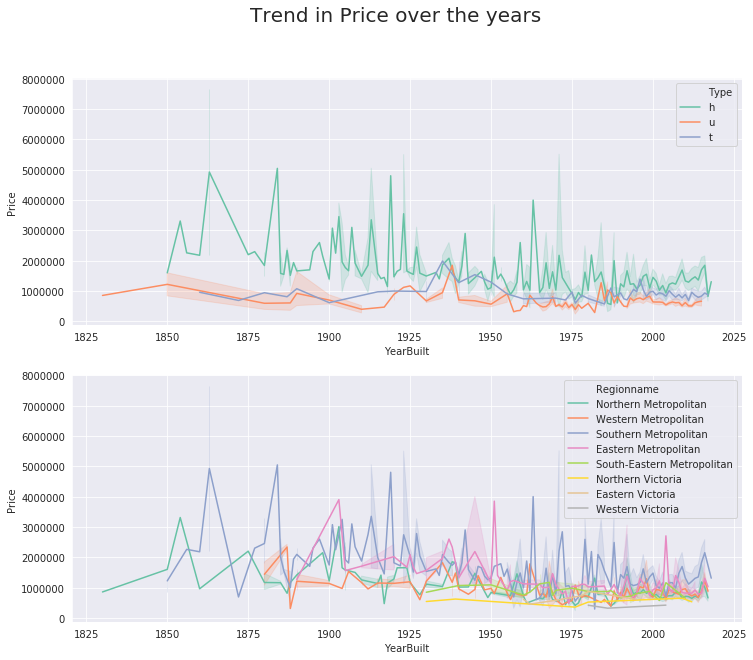

In [36]:
fig, axarr = plt.subplots(2, 1, figsize=(12, 10))

fig.suptitle('Trend in Price over the years',fontsize=20)

sns.lineplot(x='YearBuilt',y='Price',data=house,hue='Type',palette='Set2',ax=axarr[0])

sns.lineplot(x='YearBuilt',y='Price',data=house,hue='Regionname',palette='Set2',ax=axarr[1]);

In the first plot, we can observe fluctuations in the prices of houses with respect to the years in which they were constructed. Whereas prices of uniits, duplex and townhouses seems to be irrespective of the years they were built.

If we see by region,price of houses in Easteren Victoria and Northern Victoria does not seem to be affected by the year in which they were built.

Buyers in general tend to pay higher price for houses which are built before 1950 as compared to the houses built in recent years, this could indicate preference for a particular design architecture of houses build prior to 1950s.

In [37]:
correlation = house.corr()['Price']
correlation.abs().sort_values(ascending=False)[1:]


Rooms                  0.573974
BuildingArea           0.555072
Bedroom2               0.553325
Bathroom               0.536710
YearBuilt              0.309386
Car                    0.292500
Longtitude             0.245732
Lattitude              0.234426
Postcode               0.217270
price_per_unit_area    0.121787
Distance               0.103381
Landsize               0.100577
Propertycount          0.040090
Name: Price, dtype: float64

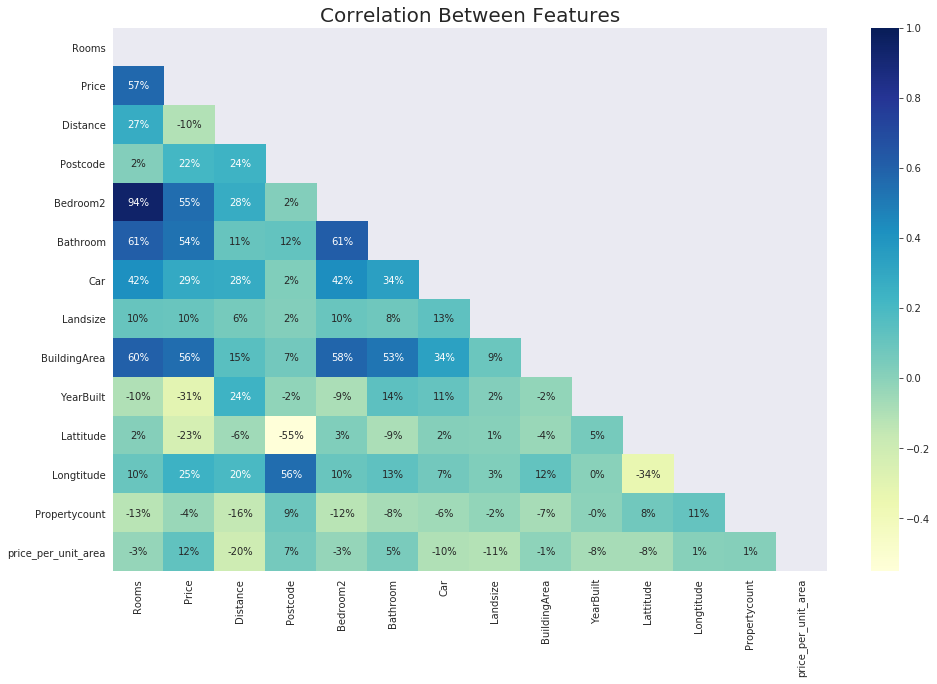

In [38]:
plt.figure(figsize=(16,10))
plt.title('Correlation Between Features', fontsize=20)
corr_matrix=house.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, annot=True, fmt = ".0%", cbar = True, cmap="YlGnBu", mask=mask);

As we saw in earlier plots:

* There is a strong negative correlation between price and Distance from central business.

* Similar is the case with year in which houses were constructed. Old properties tend to be expensive.

**Conclusions**

Sale of all three kinds of properties can be seen in Northern Metropolitan, Western Metropolitan and Southern /metropoiltan as these regions are closer to central business whereas in other areas sales of units/duplex, townhouse is negligible.

Properties which were built before 1950's tend to be more expensive.These properties are majorly located in Northern, Southern and Eastern Metropolitan area. Most expensive type of old constructed property includes house/villa type.

Type of property that is sold out most all across the mentioned areas is house/villa type.

1)Features of commonly sold properties:

* 2-3 bedrooms
* 1 bathroom
* Preferred type of property-Houses/Villa
* Preferred regions: Northern, Southern, And Western Metropolitan
* Council areas: Moreland, Boroondara, Glen Era,Darebein, Moone Valley

2)Features of expensive properties:

* Property type: House/Villas
* Present in Southern Metropolitan
* Are built in the years,1850-1925
* 5 bedrooms
* More than 5 bathrooms
* Council areas: Boroondara and Stonnington

## C. Model Build

**Scaling Features**

We use Robust Scaler for scaling, because is used if the data has data outliers, and this Scaler is not based on the mean or standard deviation. But based on IQR or median. So it is more resistant (robust) in the presence of outlier data.

In [81]:
house['Price_Scl'] = RobustScaler().fit_transform(house[['Price']])
house['Distance_Scl'] = RobustScaler().fit_transform(house[['Distance']])
house['Bedroom2_Scl'] = RobustScaler().fit_transform(house[['Bedroom2']])
house['Rooms_Scl'] = RobustScaler().fit_transform(house[['Rooms']])
house['Bathroom_Scl'] = RobustScaler().fit_transform(house[['Bathroom']])
house['YearBuilt_Scl'] = RobustScaler().fit_transform(house[['YearBuilt']])
house['Car_Scl'] = RobustScaler().fit_transform(house[['Car']])
house['Propertycount_Scl'] = RobustScaler().fit_transform(house[['Propertycount']])
house['Landsize_Scl'] = RobustScaler().fit_transform(house[['Landsize']])
house['BuildingArea_Scl'] = RobustScaler().fit_transform(house[['BuildingArea']])

house.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Price_Scl,Distance_Scl,Bedroom2_Scl,Rooms_Scl,Bathroom_Scl,YearBuilt_Scl,Car_Scl,Propertycount_Scl,Landsize_Scl,BuildingArea_Scl
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,0.179592,-1.090909,-1.0,-1.0,0.0,-0.942029,-1.0,-0.528411,-0.533007,-0.5375
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,0.764626,-1.090909,0.0,0.0,1.0,-0.942029,-1.0,-0.528411,-0.586797,0.3500
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,0.948299,-1.090909,0.0,1.0,0.0,0.710145,1.0,-0.528411,-0.621027,0.2500
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,1.323810,-1.090909,1.0,0.0,1.0,-0.797101,-1.0,-0.528411,-0.315403,1.1000
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,0.997279,-1.090909,-1.0,-1.0,0.0,-1.086957,1.0,-0.528411,-0.288509,-0.1875


### Splitting Data with 80% Train and 20% Test

In [82]:
house.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'price_per_unit_area',
       'Type_E', 'Method_E', 'Regionname_E', 'CouncilArea_E', 'Postcode_E',
       'Price_Scl', 'Distance_Scl', 'Bedroom2_Scl', 'Rooms_Scl',
       'Bathroom_Scl', 'YearBuilt_Scl', 'Car_Scl', 'Propertycount_Scl',
       'Landsize_Scl', 'BuildingArea_Scl'],
      dtype='object')

I chose a feature based on previous data correlation, and it is shown in the splitting data below.

In [105]:
X = house.drop(['Price_Scl','Price','Suburb','Address','Rooms','Type','Method','SellerG','Date','Distance','Postcode','Bedroom2',
              'Bathroom','Car','Landsize','BuildingArea','YearBuilt','CouncilArea','Lattitude','Longtitude','Regionname','Propertycount',
                'price_per_unit_area'], axis=1)

y = house['Price']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

Using Simple Linear Regression below

In [149]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [150]:
y_pred = regressor.predict(X_test)

### Model Performance

In [109]:
print('Mean Absolute Error : ', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error : ', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Max Error : ', round(metrics.max_error(y_test, y_pred)))

Mean Absolute Error :  285943.93358059175
Mean Squared Error :  197863638843.9655
Root Mean Squared Error :  444818.65838110424
Max Error :  5342847.0


### Another model

In [169]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

modelA = Ridge()
modelB = Lasso()
modelC = ElasticNet()

modelA.fit(X_train, y_train)
modelB.fit(X_train, y_train)
modelC.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [170]:
df['y"A'] = modelA.predict(X_test)
df['y"B'] = modelB.predict(X_test)
df['y"C'] = modelC.predict(X_test)

In [171]:
print('Model A Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(y_test, df['y"A'])))
print('Model B Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(y_test, df['y"B'])))
print('Model C Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(y_test, df['y"C'])))

Model A Root Mean Squared Error :  444814.79539852
Model B Root Mean Squared Error :  444818.67198395566
Model C Root Mean Squared Error :  460544.335278804


Use Decision Tree Regressor

In [148]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [120]:
DTR = DecisionTreeRegressor(random_state=0)

In [121]:
DTR.fit(X)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

RMSE from Decision Tree Regressor

In [155]:
y_pred = DTR.predict(X_test)

### Model Performance

In [158]:
print('Mean Absolute Error : ', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error : ', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Max Error : ', round(metrics.max_error(y_test, y_pred)))

Mean Absolute Error :  262608.542
Mean Squared Error :  210480855833.13
Root Mean Squared Error :  458781.92622762505
Max Error :  5450000.0


### Grid Search CV

Using hyperparameter tuning

In [163]:
param_grid_rf = {
    'max_features': [None, 100, 200, 300],
    'min_samples_split': [5, 10],
    'max_depth': [None, 5, 6],
    'criterion' : ['mse']
}

gs_rf = GridSearchCV(estimator = DTR, param_grid = param_grid_rf, cv = 10, n_jobs = -1, verbose = 2)
gs_rf = gs_rf.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished


In [164]:
print(gs_rf.best_params_)
print(gs_rf.best_score_)

{'criterion': 'mse', 'max_depth': 6, 'max_features': None, 'min_samples_split': 5}
0.6486789878240514


In [165]:
cross_val_score(gs_rf, X_train, y_train, cv = 10).mean()

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.5s finished


0.6483649279000934

Based on observation :
    
* Among all the tested model, the best was Ridge with data scaled (RobustScaler)
* But the data are still many shortcomings such as the number of existing outliers. For the better, it's better to do manual outlier detection and then scaling using minMaxScaler, possibly with a small outlier will improve the performance of our model.
* And the data we use is already fit even with scoring which is still not good when viewed using this decision tree regressor.

### Evaluation Model

From the model that has been made, I chose to use the Ridge regression model. With what I emphasize, the RMSE value with 444814 is the best compared to others. 

It can be seen that the plot below predicts the actual price with our predictions.


In [174]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': df['y"A']})
df

,Actual,Predicted
716,1125000.0,1.313640e+06
7113,1275000.0,1.465327e+06
9301,642500.0,7.706325e+05
8740,1220000.0,1.737347e+06
1190,2840000.0,1.975617e+06
...,...,...
7968,555000.0,7.386910e+05
4282,945000.0,1.010891e+06
1443,1000000.0,1.258999e+06
2614,1450000.0,1.453982e+06


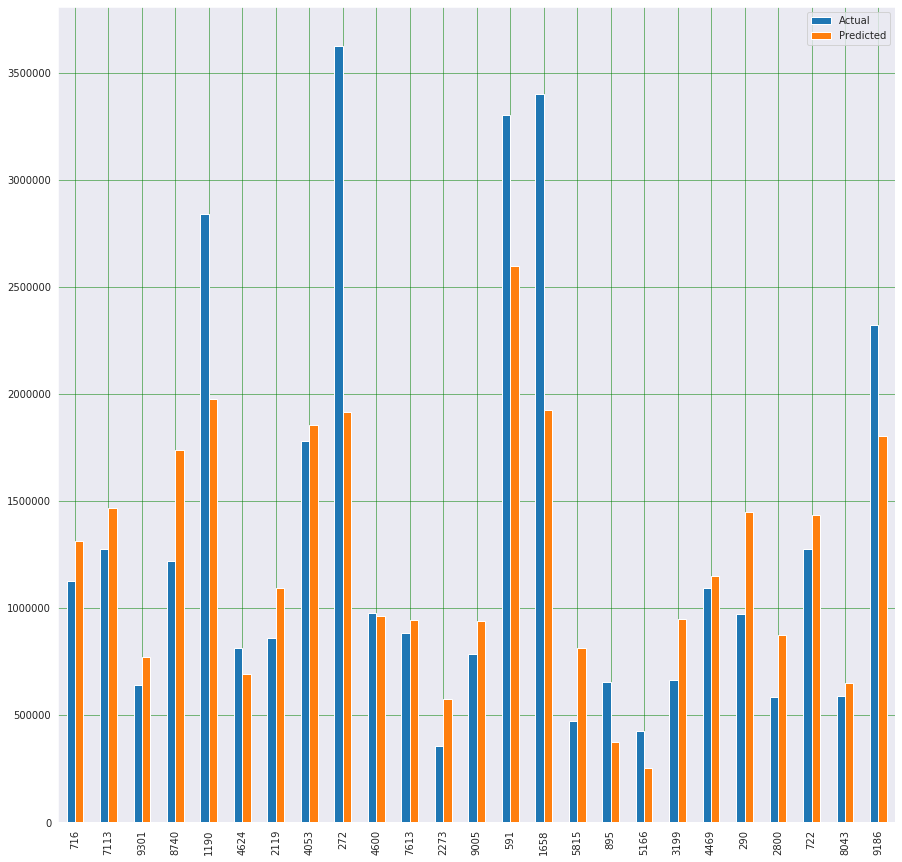

In [175]:
df1 = df.head(25)
df1.plot(kind = 'bar', figsize = (15, 15))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'green')
plt.grid(which = 'minor', linestyle = '-', linewidth = '0.5', color = 'black')
plt.show()